# Temporal Difference Learning
---
Now that we have learned a little about Monte Carlo Methods, let's move on to Temporal Difference(TD) Learning.
The plan for the week is to do a small lecture Tuesday to review the TD material then jump into an exercise.
If we complete that exercise, we will do a really fun exercise using the same TD methods Thursday.

Please watch the videos bellow.
There is not a lot of material here, but it is dense.
I recommend taking notes and reviewing the videos a few times until you have a solid understanding of the material.
Lastly, don't be afraid to review the MC control material; it is very helpful in understanding the motivation for TD learning.

[Introduction](https://www.youtube.com/watch?v=yXErXQulI_o&t=81s)

[TD Control Part 1](https://www.youtube.com/watch?v=HYV0SP9wm7g)

[TD Control Part 2](https://www.youtube.com/watch?v=U_CV-UC9G2c)

[SARSA max (Q-Learning)](https://www.youtube.com/watch?v=4DxoYuR7aZ4)

[Expected SARSA](https://www.youtube.com/watch?v=kEKupCyU0P0)


# Exercise
---

Now that we know a little about TD methods, let's put them into practice.

Run this first cell to get all the helper functions loaded.

In [1]:
import unittest
from IPython.display import Markdown, display
import numpy as np
import matplotlib.pyplot as plt

def printmd(string):
    display(Markdown(string))

V_opt = np.zeros((4,12))
V_opt[0:13][0] = -np.arange(3, 15)[::-1]
V_opt[0:13][1] = -np.arange(3, 15)[::-1] + 1
V_opt[0:13][2] = -np.arange(3, 15)[::-1] + 2
V_opt[3][0] = -13

pol_opt = np.hstack((np.ones(11), 2, 0))

V_true = np.zeros((4,12))
for i in range(3):
    V_true[0:13][i] = -np.arange(3, 15)[::-1] - i
V_true[1][11] = -2
V_true[2][11] = -1
V_true[3][0] = -17

def get_long_path(V):
    return np.array(np.hstack((V[0:13][0], V[1][0], V[1][11], V[2][0], V[2][11], V[3][0], V[3][11])))

def get_optimal_path(policy):
    return np.array(np.hstack((policy[2][:], policy[3][0])))

class Tests(unittest.TestCase):

    def td_prediction_check(self, V):
        to_check = get_long_path(V)
        soln = get_long_path(V_true)
        np.testing.assert_array_almost_equal(soln, to_check)

    def td_control_check(self, policy):
        to_check = get_optimal_path(policy)
        np.testing.assert_equal(pol_opt, to_check)

check = Tests()

def run_check(check_name, func):
    try:
        getattr(check, check_name)(func)
    except check.failureException as e:
        printmd('**<span style="color: red;">PLEASE TRY AGAIN</span>**')
        return
    printmd('**<span style="color: green;">PASSED</span>**')

def plot_values(V):
	# reshape the state-value function
	V = np.reshape(V, (4,12))
	# plot the state-value function
	fig = plt.figure(figsize=(15,5))
	ax = fig.add_subplot(111)
	im = ax.imshow(V, cmap='cool')
	for (j,i),label in np.ndenumerate(V):
	    ax.text(i, j, np.round(label,3), ha='center', va='center', fontsize=14)
	plt.tick_params(bottom='off', left='off', labelbottom='off', labelleft='off')
	plt.title('State-Value Function')
	plt.show()

Next let's take a look at the environment.
For this exercise we will use the cliff walking environment.
This is an example of a grid world.
If you want to take a look at the source code, check here [CliffWalking](https://github.com/openai/gym/blob/master/gym/envs/toy_text/cliffwalking.py).

In [2]:
import sys
import gym
import numpy as np
from collections import defaultdict, deque
%matplotlib inline


In [3]:
env = gym.make('CliffWalking-v0')

The agent moves through a $4\times 12$ gridworld, with states numbered as follows:
```
[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
 [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]]
```
At the start of any episode, state `36` is the initial state.  State `47` is the only terminal state, and the cliff corresponds to states `37` through `46`.

The agent has 4 potential actions:
```
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3
```

Thus, $\mathcal{S}^+=\{0, 1, \ldots, 47\}$, and $\mathcal{A} =\{0, 1, 2, 3\}$.

As with the previous gym environment, we can examine this directly.

In [4]:
print(env.action_space)
print(env.observation_space)

Discrete(4)
Discrete(48)


The goal of today's exercise is to find the value function and therefore the policy for the environment.
As a quick reminder, the optimal policy is a function that maps from a given state to the best action.
Grid worlds are a great place to start because visualizing the optimal state-value function is easy.
In the figure below, we visualize the optimal state-value function for this environment.

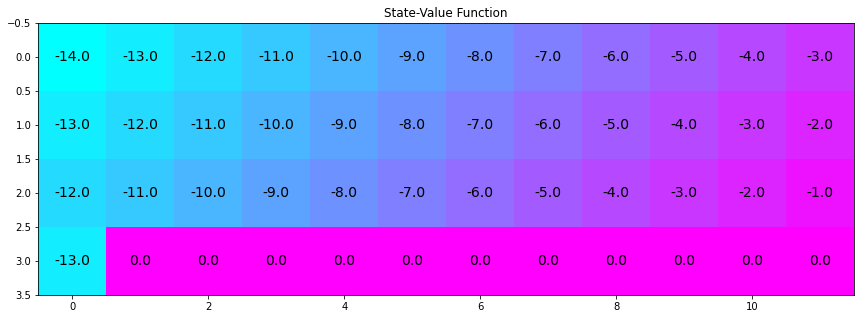

In [5]:
# define the optimal state-value function
V_opt = np.zeros((4,12))
V_opt[0:13][0] = -np.arange(3, 15)[::-1]
V_opt[0:13][1] = -np.arange(3, 15)[::-1] + 1
V_opt[0:13][2] = -np.arange(3, 15)[::-1] + 2
V_opt[3][0] = -13

plot_values(V_opt)

## 1. Sarsa

The first algorithm we will implement is SARSA.
It is a fairly simple algorithm but has its tricky points.

The defining trait of SARSA is that all actions are chosen with the epsilon greedy policy, and the value of all state-value pairs are estimated with the epsilon greedy policy.
Read the pseudocode carefully, and you should be just fine.

"Well, maybe..."

\-Less Claypool

### SARSA Pseudocode
---

initialize epsilon

for episode in num_episodes:

    decay epsilon
    state <- initial state
    chose action from Q with epsilon greedy policy
    t <- 0
    repeat until terminal state:
        take action A_t and observe R_t+1, S_t+1
        chose action A_t+1 from Q with epsilon greedy policy
        update Q-table
        S <- S_t+1
        A <- A_t+1
---

Recall that the Q-table update for SARSA is:
$$Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha (R_{t+1} + \gamma Q(S_{t+1}, A_{t+1}) - Q(S_t, A_t))$$

In [6]:
def sarsa(env, num_episodes, alpha, gamma=1.0):
    """
    SARSA Algorithm
    :param env: open ai gym environment
    :param num_episodes: number of episodes to run
    :param alpha: weight for the Q-tabel running average
    :param gamma: discount factor for future rewards
    :return: (dict) Q-table and (list) score for each episode
    """
    # useful for epsilon greedy action selection...
    num_actions = env.action_space.n

    # initialize action-value function (empty dictionary of arrays)
    Q = defaultdict(lambda: np.zeros(env.nA))

    # initialize performance monitor
    scores = []

    # epsilon decay parameters
    eps = 1
    eps_decay = 0.9
    eps_end = 0.000001

    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        # decay epsilon
        eps = max(eps * eps_decay, eps_end)

        ## TODO: complete the function by implementing the remaining pseudocode
        ## HINT: env.reset() returns the initial state
        ## HINT: env.step() takes an int (action) and returns a tuple of (next_state, reward, done, info)

        # reward tracking, for plotting later
        total_reward = 0

        # algorithm
        # get initial state
        state = env.reset()

        # epsilon greedy action
        if np.random.uniform() < eps:
            action = np.random.choice(np.arange(num_actions))
        else:
            action = np.argmax(Q[state])

        # repeat until terminal state
        done = False
        while not done:
            # take step in environment
            next_state, reward, done, info = env.step(action)

            # for plotting later, not part of algorithm
            total_reward += reward

            # epsilon greedy next action
            if np.random.uniform() < eps:
                next_action = np.random.choice(np.arange(num_actions))
            else:
                next_action = np.argmax(Q[next_state])

            # update Q table
            current_value = Q[state][action]
            next_value = Q[next_state][next_action]
            Q[state][action] = current_value + alpha * (reward + gamma * next_value - current_value)

            # update state and action
            state = next_state
            action = next_action
        
        # for plottting later
        scores.append(total_reward)
    return Q, scores

**PASSED** indicates that your Q-table is sufficiently close to the true value, well done!
**PLEASE TRY AGAIN** indicates that you have a little more work to do.

**IMPORTANT** For the tests to pass you can change num_episodes and alpha, but you must leave gamma in the default value.
Once the tests pass, and your function is working correctly, then feel free to alter gamma.

Episode 10000/10000

**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 1  0  0  1  1  1  1  1  0  1  0  2]
 [ 2  1  1  1  2  1  1  1  2  1  2  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]


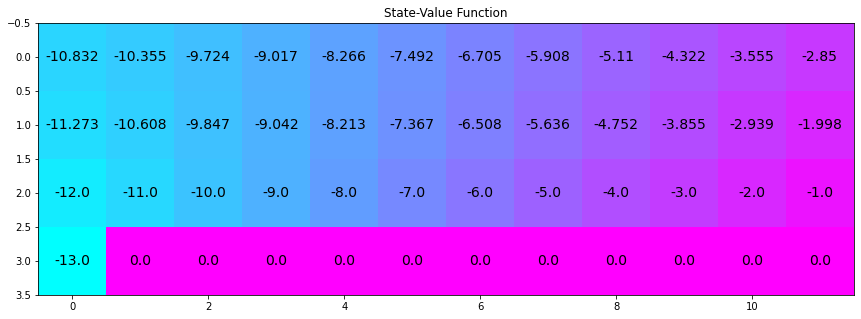

In [7]:
np.random.seed(2)
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsa, scores_sarsa = sarsa(env, num_episodes=10000, alpha=0.01)

# print the estimated optimal policy
policy_sarsa = np.array([np.argmax(Q_sarsa[key]) if key in Q_sarsa else -1 for key in np.arange(48)]).reshape(4,12)
run_check('td_control_check', policy_sarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsa)

# plot the estimated optimal state-value function
V_sarsa = ([np.max(Q_sarsa[key]) if key in Q_sarsa else 0 for key in np.arange(48)])
plot_values(V_sarsa)

## 2. SARSA Max a.k.a Q-learning

SARSA Max is very similar to SARSA.
The main difference comes in the update step for the Q-table.
SARSA Max estimates the value of the next state by taking the max value over all action in that state.
This is in contrast to SARSA, which estimated the value of the next state by choosing an action with an epsilon greedy policy and using that state-action pair to estimate the value.

Put simply, SARSA Max estimates the value of the next state according to best known policy rather than estimating the value with a semi-stochastic policy.

Makes you wonder why you had to implement SARSA in the first place...

"Can't be starting all these problems if you cannot solve them."

\-Cardi B

### SARSA Max (Q-learning) Pseudocode
---

initialize epsilon

for episode in num_episodes:

    decay epsilon
    state <- initial state
    t <- 0
    repeat until terminal state:
        chose action from Q epsilon greedy policy
        take action A_t and observe R_t+1, S_t+1
        **chose action A_t+1 from max value in Q-table for S_t+1**
        update Q-table
        S_t <- S_t+1

---

Recall that the Q-table update for SARSA Max is:
$$Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha (R_{t+1} + \gamma \max_{a \in A}Q(S_{t+1}, a) - Q(S_t, A_t))$$

In [8]:
def q_learning(env, num_episodes, alpha, gamma=1.0):
    """
    Q-learning Algorithm
    :param env: open ai gym environment
    :param num_episodes: number of episodes to run
    :param alpha: weight for the Q-tabel running average
    :param gamma: discount factor for future rewards
    :return: (dict) Q-table and (list) score for each episode
    """
    # useful for epsilon greedy action selection...
    num_actions = env.action_space.n

    # initialize action-value function (empty dictionary of arrays)
    Q = defaultdict(lambda: np.zeros(env.nA))

    # initialize performance monitor
    scores = []

    # epsilon decay parameters
    eps = 1
    eps_decay = 0.9
    eps_end = 0.000001

    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        # decay epsilon
        eps = max(eps * eps_decay, eps_end)

        ## TODO: complete remaining pseudocode
        ## HINT: env.reset() returns the initial state
        ## HINT: env.step() takes an int (action) and returns a tuple of (next_state, reward, done, info)

        # reward tracking, for plotting later
        total_reward = 0

        # get initial state
        state = env.reset()

        # repeat until in terminal state
        done = False
        while not done:
            # epsilon greedy action
            if np.random.uniform() < eps:
                action = np.random.choice(np.arange(num_actions))
            else:
                action = np.argmax(Q[state])

            # take step in environment
            next_state, reward, done, info = env.step(action)

            # for plotting later, not part of algorithm
            total_reward += reward

            # get next action
            next_action = np.argmax(Q[next_state])

            # update Q
            current_value = Q[state][action]
            next_value = Q[next_state][next_action]
            Q[state][action] = current_value + alpha * (reward + gamma * next_value - current_value)

            # update state
            state = next_state
        
        # for plotting later
        scores.append(total_reward)

    return Q, scores

**PASSED** indicates that your Q-table is sufficiently close to the true value, well done!
**PLEASE TRY AGAIN** indicates that you have a little more work to do.

**IMPORTANT** For the tests to pass you can change num_episodes and alpha, but you must leave gamma in the default value.
Once the tests pass, and your function is working correctly, then feel free to alter gamma.

Episode 10000/10000

**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 3  0  2  0  1  1  0  3  3  1  1  1]
 [ 0  0  3  1  1  2  1  1  2  2  2  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]


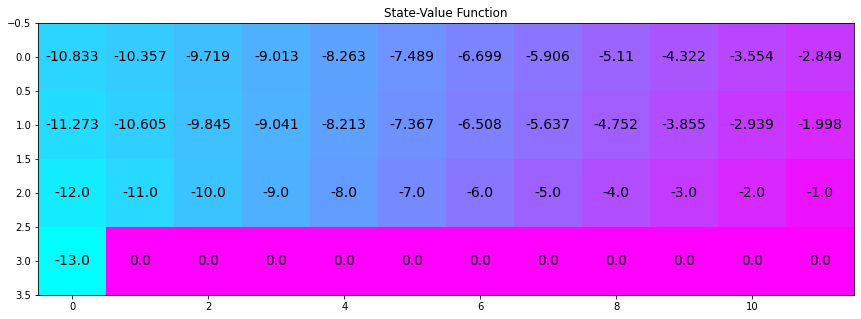

In [9]:
np.random.seed(2)
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsamax, scores_sarsamax = q_learning(env, num_episodes=10000, alpha=0.01)

# print the estimated optimal policy
policy_sarsamax = np.array([np.argmax(Q_sarsamax[key]) if key in Q_sarsamax else -1 for key in np.arange(48)]).reshape((4,12))
run_check('td_control_check', policy_sarsamax)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsamax)

# plot the estimated optimal state-value function
plot_values([np.max(Q_sarsamax[key]) if key in Q_sarsamax else 0 for key in np.arange(48)])

## 3. Expected SARSA

Lastly we will implement Expected SARSA.
This will hearken back to our early days of sums over probabilities.

Yay....

As with SARSA Max we will choose the next action using the Q-table with an epsilon greedy policy.
But when we update Q(S_t, A_t) we will use the **expected** value of next state action pair.
This expected value utilizes our good old friend the product rule!

Yay...

Where the expected value for any action is the estimated value times the probability of choosing that action according to the policy.

It is otherwise very similar to SARSA Max...

"You'll never get out of this maze!"

\-Phish

## Expected SARSA Pseudocode
---

initialize epsilon

    decay epsilon
    state <- initial state
    t <- 0
    repeat until terminal state:
        chose action from Q with epsilon greedy policy
        take action A_t and observe R_t+1, S_t+1
        **chose action A_t+1 from max value in Q-table for S_t+1**
        update Q-table
        S_t <- S_t+1

---

Recall that the Q-table update for SARSA Max is:
$$Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha (R_{t+1} + \gamma \sum_{a \in A}\pi(a \vert S_{t+1})Q(S_{t+1}, a) - Q(S_t, A_t))$$

$\pi(a \vert S_{t+1}) = \Bigg\{$
$\begin{array}{rcl}
                            1 - \epsilon + \frac{\epsilon}{\text{num_actions}} & \mbox{for} & \text{arg}\max_{a \in A}Q(S_{t+1}, a) \\
                            \frac{\epsilon}{\text{num_actions}} & \mbox{for} & \neg{\text{arg}\max_{a \in A}Q(S_{t+1}, a) }
                            \end{array}
                            $


In [10]:
def expected_sarsa(env, num_episodes, alpha, gamma=1.0):
    """
    Expected SARSA Algorithm
    :param env: open ai gym environment
    :param num_episodes: number of episodes to run
    :param alpha: weight for the Q-tabel running average
    :param gamma: discount factor for future rewards
    :return: (dict) Q-table and (list) score for each episode
    """
    # useful for epsilon greedy action selection...
    num_actions = env.action_space.n

    # initialize action-value function (empty dictionary of arrays)
    Q = defaultdict(lambda: np.zeros(env.nA))

    # initialize performance monitor
    scores = []

    # epsilon decay parameters
    eps = 1
    eps_decay = 0.9
    eps_end = 0.000001
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        # decay epsilon
        eps = max(eps * eps_decay, eps_end)

        ## TODO: complete the remaining pseudocode
        ## HINT: env.reset() returns the initial state
        ## HINT: env.step() takes an int (action) and returns a tuple of (next_state, reward, done, info)

        # reward tracking for plotting later, not part of the algorithm
        total_reward = 0

        # get initial state
        state = env.reset()

        # repeat until terminal state
        done = False
        while not done:
            # epsilon greedy action
            if np.random.uniform() < eps:
                action = np.random.choice(np.arange(num_actions))
            else:
                action = np.argmax(Q[state])

            # take action and observe next state and reward
            next_state, reward, done, info = env.step(action)

            # for plotting later
            total_reward += reward

            # get next action
            next_action = np.argmax(Q[next_state])

            # update Q table
            current = Q[state][action]
            policy = np.full(4, eps / num_actions)
            policy[next_action] += 1 - eps
            expected = np.dot(policy, Q[next_state])
            Q[state][action] = current + alpha * (reward + expected - current)

            # update state
            state = next_state

        # for plotting latter
        scores.append(total_reward)

    return Q, scores

**PASSED** indicates that your Q-table is sufficiently close to the true value, well done!
**PLEASE TRY AGAIN** indicates that you have a little more work to do.

**IMPORTANT** For the tests to pass you can change num_episodes and alpha, but you must leave gamma in the default value.
Once the tests pass, and your function is working correctly, then feel free to alter gamma.

Episode 10000/10000

**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 0  3  3  1  1  0  2  2  1  1  1  2]
 [ 0  1  1  0  1  2  2  1  1  2  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]


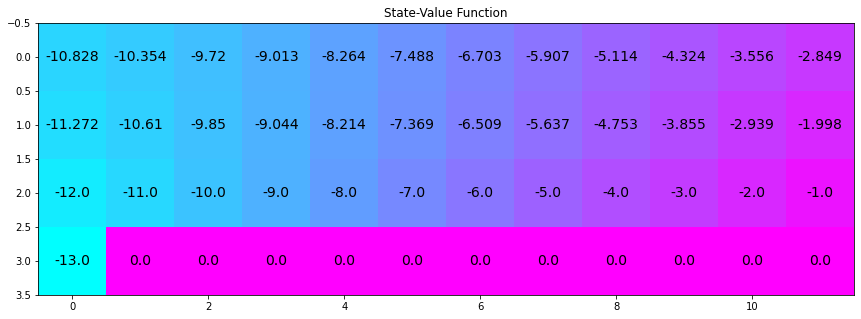

In [11]:
# obtain the estimated optimal policy and corresponding action-value function
Q_expsarsa, scores_exp_sarsa = expected_sarsa(env, num_episodes=10000, alpha=0.01)

# print the estimated optimal policy
policy_expsarsa = np.array([np.argmax(Q_expsarsa[key]) if key in Q_expsarsa else -1 for key in np.arange(48)]).reshape(4,12)
run_check('td_control_check', policy_expsarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_expsarsa)

# plot the estimated optimal state-value function
plot_values([np.max(Q_expsarsa[key]) if key in Q_expsarsa else 0 for key in np.arange(48)])

## 4. Performance Comparison
---
Use the scores list from each algorithm to plot the 5 episode moving average.

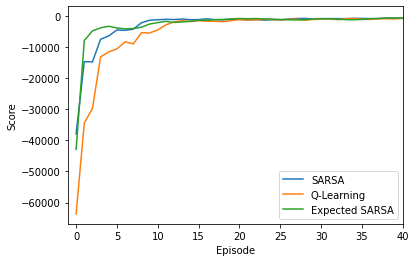

In [12]:
avg_sarsa = np.convolve(np.array(scores_sarsa), np.ones(5), mode="valid")
avg_sarsamax = np.convolve(np.array(scores_sarsamax), np.ones(5), mode="valid")
avg_exp_sarsa = np.convolve(np.array(scores_exp_sarsa), np.ones(5), mode="valid")
plt.plot(np.arange(len(avg_sarsa)), avg_sarsa, label="SARSA")
plt.plot(np.arange(len(avg_sarsamax)), avg_sarsamax, label="Q-Learning")
plt.plot(np.arange(len(avg_exp_sarsa)), avg_exp_sarsa, label="Expected SARSA")
plt.xlabel("Episode")
plt.ylabel("Score")
plt.xlim(-1, 40)
plt.legend()
plt.show()